##We follow the open source codes from https://github.com/NVlabs/edm2 for both dataset construction and diffusion model training.
##You can directly use the models we trained or retrain the new model following the instruction from the above website.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
from time import time
import dnnlib

In [2]:
class GaussianMixture(torch.nn.Module):
    def __init__(self,
        phi,                        # Per-component weight: [comp]
        mu,                         # Per-component mean: [comp, dim]
        Sigma,                      # Per-component covariance matrix: [comp, dim, dim]
        sample_lut_size = 64<<10,   # Lookup table size for efficient sampling.
    ):
        super().__init__()
        self.register_buffer('phi', torch.tensor(np.asarray(phi) / np.sum(phi), dtype=torch.float32))
        self.register_buffer('mu', torch.tensor(np.asarray(mu), dtype=torch.float32))
        self.register_buffer('Sigma', torch.tensor(np.asarray(Sigma), dtype=torch.float32))

        # Precompute eigendecompositions of Sigma for efficient heat diffusion.
        L, Q = torch.linalg.eigh(self.Sigma) # Sigma = Q @ L @ Q
        self.register_buffer('_L', L) # L: [comp, dim, dim]
        self.register_buffer('_Q', Q) # Q: [comp, dim, dim]

        # Precompute lookup table for efficient sampling.
        self.register_buffer('_sample_lut', torch.zeros(sample_lut_size, dtype=torch.int64))
        phi_ranges = (torch.cat([torch.zeros_like(self.phi[:1]), self.phi.cumsum(0)]) * sample_lut_size + 0.5).to(torch.int32)
        for idx, (begin, end) in enumerate(zip(phi_ranges[:-1], phi_ranges[1:])):
            self._sample_lut[begin : end] = idx

    # Evaluate the terms needed for calculating PDF and score.
    def _eval(self, x, sigma=0):                                                    # x: [..., dim], sigma: [...]
        L = self._L + sigma[..., None, None] ** 2                                   # L' = L + sigma * I: [..., dim]
        d = L.prod(-1)                                                              # d = det(Sigma') = det(Q @ L' @ Q) = det(L'): [...]
        y = self.mu - x[..., None, :]                                               # y = mu - x: [..., comp, dim]
        z = torch.einsum('...ij,...j,...kj,...k->...i', self._Q, 1 / L, self._Q, y) # z = inv(Sigma') @ (mu - x): [..., comp, dim]
        c = self.phi / (((2 * np.pi) ** x.shape[-1]) * d).sqrt()                    # normalization factor of N(x; mu, Sigma')
        w = c * (-1/2 * torch.einsum('...i,...i->...', y, z)).exp()                 # w = N(x; mu, Sigma'): [..., comp]
        return z, w

    # Calculate p(x; sigma) for the given sample points, processing at most the given number of samples at a time.
    def pdf(self, x, sigma=0, max_batch_size=1<<14):
        sigma = torch.as_tensor(sigma, dtype=torch.float32, device=x.device).broadcast_to(x.shape[:-1])
        x_batches = x.flatten(0, -2).split(max_batch_size)
        sigma_batches = sigma.flatten().split(max_batch_size)
        pdf_batches = [self._eval(xx, ss)[1].sum(-1) for xx, ss in zip(x_batches, sigma_batches)]
        return torch.cat(pdf_batches).reshape(x.shape[:-1]) # x.shape[:-1]

    # Calculate log(p(x; sigma)) for the given sample points, processing at most the given number of samples at a time.
    def logp(self, x, sigma=0, max_batch_size=1<<14):
        return self.pdf(x, sigma, max_batch_size).log()

    # Calculate \nabla_x log(p(x; sigma)) for the given sample points.
    def score(self, x, sigma=0):
        sigma = torch.as_tensor(sigma, dtype=torch.float32, device=x.device).broadcast_to(x.shape[:-1])
        z, w = self._eval(x, sigma)
        w = w[..., None]
        return (w * z).sum(-2) / w.sum(-2) # x.shape

    # Draw the given number of random samples from p(x; sigma).
    def sample(self, shape, sigma=0, generator=None):
        sigma = torch.as_tensor(sigma, dtype=torch.float32, device=self.mu.device).broadcast_to(shape)
        i = self._sample_lut[torch.randint(len(self._sample_lut), size=sigma.shape, device=sigma.device, generator=generator)]
        L = self._L[i] + sigma[..., None] ** 2                                                  # L' = L + sigma * I: [..., dim]
        x = torch.randn(L.shape, device=sigma.device, generator=generator)                      # x ~ N(0, I): [..., dim]
        y = torch.einsum('...ij,...j,...kj,...k->...i', self._Q[i], L.sqrt(), self._Q[i], x)    # y = sqrt(Sigma') @ x: [..., dim]
        return y + self.mu[i] # [..., dim]

In [3]:
def gt(classes='A', device=torch.device('cpu'), seed=2, origin=np.array([0.0030, 0.0325]), scale=np.array([1.3136, 1.3844])):
    rnd = np.random.RandomState(seed)
    comps = []

    # Recursive function to generate a given branch of the distribution.
    def recurse(cls, depth, pos, angle):
        if depth >= 7:
            return

        # Choose parameters for the current branch.
        dir = np.array([np.cos(angle), np.sin(angle)])
        dist = 0.292 * (0.8 ** depth) * (rnd.randn() * 0.2 + 1)
        thick = 0.2 * (0.8 ** depth) / dist
        size = scale * dist * 0.06

        # Represent the current branch as a sequence of Gaussian components.
        for t in np.linspace(0.07, 0.93, num=8):
            c = dnnlib.EasyDict()
            c.cls = cls
            c.phi = dist * (0.5 ** depth)
            c.mu = (pos + dir * dist * t) * scale
            c.Sigma = (np.outer(dir, dir) + (np.eye(2) - np.outer(dir, dir)) * (thick ** 2)) * np.outer(size, size)
            comps.append(c)

        # Generate each child branch.
        for sign in [1, -1]:
            recurse(cls=cls, depth=(depth + 1), pos=(pos + dir * dist), angle=(angle + sign * (0.7 ** depth) * (rnd.randn() * 0.2 + 1)))

    # Generate each class.
    recurse(cls='A', depth=0, pos=origin, angle=(np.pi * 0.25))
    recurse(cls='B', depth=0, pos=origin, angle=(np.pi * 1.25))

    # Construct a GaussianMixture object for the selected classes.
    sel = [c for c in comps if c.cls in classes]
    distrib = GaussianMixture([c.phi for c in sel], [c.mu for c in sel], [c.Sigma for c in sel])
    return distrib.to(device)

In [4]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)
    
def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

In [5]:
def normalize(x, dim=None, eps=1e-4):
    if dim is None:
        dim = list(range(1, x.ndim))
    norm = torch.linalg.vector_norm(x, dim=dim, keepdim=True, dtype=torch.float32)
    norm = torch.add(eps, norm, alpha=np.sqrt(norm.numel() / x.numel()))
    # norm1 = torch.linalg.vector_norm(x, dim=dim, keepdim=True, dtype=torch.float32)
    # norm2 = torch.add(eps, norm1, alpha=np.sqrt(norm1.numel() / x.numel()))
    # result = x / norm2.to(x.dtype)
    # result = x 
    return x / norm.to(x.dtype)

class MPSiLU(torch.nn.Module):
    def forward(self, x):
        return torch.nn.functional.silu(x) / 0.596

class MPLinear(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(out_dim, in_dim))

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                self.weight.copy_(normalize(self.weight))
        w = normalize(self.weight) / np.sqrt(self.weight[0].numel())
        return x @ w.t()

def std_to_exp(std):
    std = np.float64(std)
    tmp = std.flatten() ** -2
    exp = [np.roots([1, 7, 16 - t, 12 - t]).real.max() for t in tmp]
    exp = np.float64(exp).reshape(std.shape)
    return exp

def power_function_beta(std, t_next, t_delta):
    beta = (1 - t_delta / t_next) ** (std_to_exp(std) + 1)
    return beta

In [6]:
class ToyModel(torch.nn.Module):
    def __init__(self,
        in_dim      = 2,    # Input dimensionality.
        num_layers  = 4,    # Number of hidden layers.
        hidden_dim  = 64,   # Number of hidden features.
        sigma_data  = 0.5,  # Expected standard deviation of the training data.
    ):
        super().__init__()
        self.sigma_data = sigma_data
        self.layers = torch.nn.Sequential()
        self.layers.append(MPLinear(in_dim + 2, hidden_dim))
        for _layer_idx in range(num_layers):
            self.layers.append(MPSiLU())
            self.layers.append(MPLinear(hidden_dim, hidden_dim))
        self.gain = torch.nn.Parameter(torch.zeros([]))

    def forward(self, x, sigma=0):
        sigma = torch.as_tensor(sigma, dtype=torch.float32, device=x.device).broadcast_to(x.shape[:-1]).unsqueeze(-1)
        x = x / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        y = self.layers(torch.cat([x, sigma.log() / 4, torch.ones_like(sigma)], dim=-1))
        z = (y ** 2).mean(-1) * self.gain / sigma.squeeze(-1) - 0.5 * (x ** 2).sum(-1) # preconditioning
        return z

    def logp(self, x, sigma=0):
        return self(x, sigma)

    def pdf(self, x, sigma=0):
        logp = self.logp(x, sigma=sigma)
        pdf = (logp - logp.max()).exp()
        return pdf

    def score(self, x, sigma=0, graph=False):
        x = x.detach().requires_grad_(True)
        logp = self.logp(x, sigma=sigma)
        score = torch.autograd.grad(outputs=[logp.sum()], inputs=[x], create_graph=graph)[0]
        return score

##We modified the following function to return both the samples and the corresponding accumulated score differences.

In [7]:
def sampling_with_nv_gap_track(net, x_init, guidance=3, gnet=None,print_flg=False, num_steps=32, sigma_min=0.002, sigma_max=5, rho=7):
    # Guided denoiser.
    def denoise(x, sigma):
        net_score = net.score(x, sigma)
        if gnet is not None:
            gnet_score = gnet.score(x, sigma)
            score = gnet_score.lerp(net_score, guidance)
            # print(score.shape)
            nv_gap = torch.norm((sigma ** 2)*(net_score-gnet_score),dim=-1)
            if print_flg:
                print(nv_gap)
                time.sleep(0.1)
        return x + score * (sigma ** 2), nv_gap

    # Time step discretization.
    nv_gap = torch.zeros(num_steps,len(x_init)).cuda()
    # print(nv_gap.requires_grad)
    step_indices = torch.arange(num_steps, dtype=torch.float32, device=x_init.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_cur = x_init
    trajectory = [x_cur]
    for i, (t_cur, t_next) in tqdm(enumerate(zip(t_steps[:-1], t_steps[1:]))): # 0, ..., N-1

        # Euler step.
        inter_d,cur_gap = denoise(x_cur, t_cur)
        d_cur = (x_cur - inter_d) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        nv_gap[i] = cur_gap
        # print(cur_gap)

        # Apply 2nd order correction.
        if i < num_steps - 1:
            inter_d,prime_gap = denoise(x_next, t_next) 
            d_prime = (x_next - inter_d) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
            nv_gap[i] = nv_gap[i] + prime_gap  #second order correction也算上nv gap了，直接加
            # print(prime_gap)

        # Record trajectory.
        x_cur = x_next
        trajectory.append(x_cur)
    return x_cur,nv_gap.t()


##We plot the color-coded samples with the following function

In [8]:
def plot_samples(samples,nv_gap=None,size=5,color_system = 1,view_x=0.30, view_y=0.30, view_size=1.2, grid_resolution=400,device=torch.device('cuda')):
    gridx = torch.linspace(view_x - view_size, view_x + view_size, steps=grid_resolution, device=device)
    gridy = torch.linspace(view_y - view_size, view_y + view_size, steps=grid_resolution, device=device)
    gridxy = torch.stack(torch.meshgrid(gridx, gridy, indexing='xy'), axis=-1)
    plt.xlim(float(gridx[0]), float(gridx[-1]))
    plt.ylim(float(gridy[0]), float(gridy[-1]))
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()

    def contours(values, levels, colors=None, cmap=None, alpha=1, linecolors='black', linealpha=1, linewidth=2.5):
        values = -(values.max() - values).sqrt().cpu().numpy()
        plt.contourf(gridx.cpu().numpy(), gridy.cpu().numpy(), values, levels=levels, antialiased=True, extend='max', colors=colors, cmap=cmap, alpha=alpha)
        plt.contour(gridx.cpu().numpy(), gridy.cpu().numpy(), values, levels=levels, antialiased=True, colors=linecolors, alpha=linealpha, linestyles='solid', linewidths=linewidth) 
    def points(pos, color='black', alpha=1, size=30):
        plt.plot(*pos.cpu().numpy().T, '.', markerfacecolor='black', markeredgecolor='none', color=color, alpha=alpha, markersize=size)

    contours(gt('AB', device).logp(gridxy), levels=[-2.12, 0], colors=[[0.9,0.9,0.9]], linecolors=[[0.7,0.7,0.7]], linewidth=1.5)
    contours(gt('A', device).logp(gridxy), levels=[-2.12, 0], colors=[[1.0,0.8,0.6]], linecolors=[[0.8,0.6,0.5]], linewidth=1.5)
    if nv_gap==None:
        points(samples, size=6, alpha=0.2)
    else:
        if color_system ==1:
            plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), c=nv_gap.cpu(), cmap=plt.cm.tab10,s=size,alpha=1)
        else:
            plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), c=nv_gap.cpu(), cmap=plt.cm.hot,s=size,alpha=1)
        cbar = plt.colorbar() 
        cbar.ax.tick_params(labelsize=21)
        # cbar.pad = 0.001
        # plt.subplots_adjust(right=1.85)

##Conduct the sampling and plot the figures.

In [9]:
data_size = 10000
device = torch.device('cuda')
x_init = gt('A', device).sample(data_size, sigma=5, generator=torch.Generator(device).manual_seed(1))

model_good = ToyModel(num_layers=4,hidden_dim=64).to(device)
model_good.load_state_dict(torch.load("good_version_trial1_4096.pkl"))
model_bad = ToyModel(num_layers=4,hidden_dim=32).to(device)
model_bad.load_state_dict(torch.load("uncondition_trial3_0512.pkl"))

sample_points_ome2,om2_gap = sampling_with_nv_gap_track(net=model_good, x_init=x_init, guidance=2, gnet=model_bad,print_flg=False)

32it [00:00, 96.03it/s] 


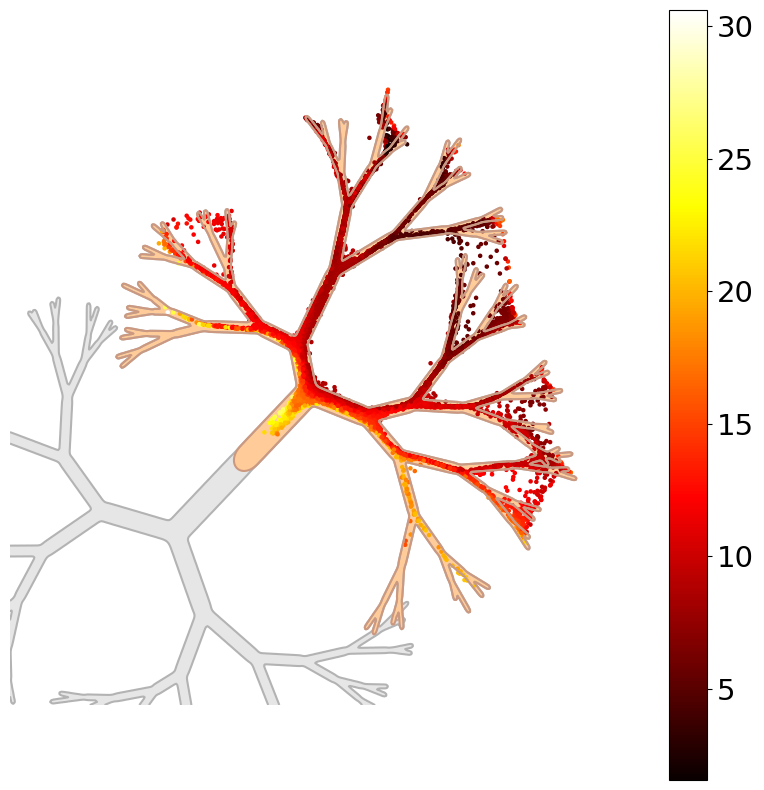

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.figure(figsize=(10,10))
plot_samples(sample_points_ome2,torch.sum(om2_gap,dim=-1),color_system=2)
plt.show()

##For a quantitative analysis, we divide ASD into 50 bins and plot the mean log-probability density of samples in each bin.

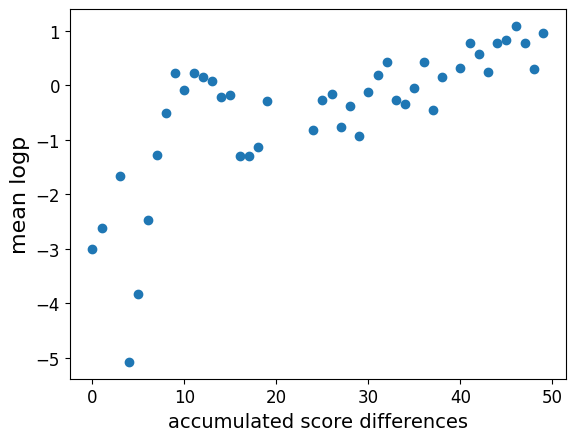

In [11]:
om2_gap_sum = torch.sum(om2_gap,dim=-1)
sorted_sum,sorted_idx = torch.sort(om2_gap_sum)
distrib = gt("AB",device)
om2_logp = distrib.logp(sample_points_ome2)
logp_list = []

for i in range(50):
    current_idx = sorted_idx[i*200:(i+1)*200]
    current_logp = om2_logp[current_idx]
    logp_list.append(torch.mean(current_logp).cpu())

plt.scatter(np.linspace(0,49,50),logp_list)
plt.xlabel("accumulated score differences", fontsize=14)
plt.ylabel("mean logp", fontsize=16)
plt.tick_params(axis='both', labelsize=12)